# <u>Chapter 4</u>: Extracting Sentiments from Product Reviews

Deciphering the emotional tone behind a sequence of words finds extensive utility in analyzing survey responses, customer feedback, or product reviews. In particular, the advent of social networks offered new possibilities for people to express their opinions on various issues instantly. Therefore, it is not surprising that many shareholders like companies, academia, or government aim to exploit public opinion on various topics and acquire valuable insight. 
The focus of this chapter is another typical problem in natural language processing, called `Sentiment analysis`, which is the extraction of sentiment from a piece of text. 

We will focus on extracting the sentiment of a corpus taken from [Snap](https://snap.stanford.edu/data/web-Amazon-links.html).

To install graphviz follow the instructions at https://graphviz.gitlab.io/download/


For Windows users:
 
If you get _ERROR: Could not install packages due to an OSError_ during the installation of the packages you need to enable long path names in the Windows registry.

In [89]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'pandas', 'matplotlib', 'seaborn', 'scikit-learn', 'numpy', 'tensorflow', 'keras', 'pydot'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Now, download the datasets.

In [ ]:
import os

# Check if the data directory already exists.
if not os.path.exists("data"):
    # URL of the zip data file to download.
    url = "https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/raw/main/chapter-04/data.zip"

    # If it doesn't exist, download the zip file.
    !wget {url}

    # Unzip the file into the "data" folder.
    !unzip -q "data.zip"


# Check if the images directory already exists.
if not os.path.exists("images"):
  !mkdir images

## Exploratory data analysis

We start with an exploratory data analysis as in every machine learning problem. Before we start an in-depth analysis, we extract some basic information from the corpus. Then, we generate different plots to shed some light on the dataset and avoid possible pitfalls in the subsequent analysis.

First, we create the method to obtain the product categories from a file.

In [90]:
import gzip
import pandas as pd

pd.options.mode.chained_assignment = None

# Method for reading the categories file.
def readCategories(filename):
  i, productId, d = 0, '', {}
  f = gzip.open(filename, 'rb')

  # Iterate over all lines in the file.
  for l in f:
    spacesPos = l.find(b' ')
    l = l.strip().decode("latin-1")
    
    # Check whether we are reading a product id or a product category.
    if spacesPos != -1:
      # The categories are separated by a comma.
      for c in l.split(','):
        # Store the category for a specific product.
        d[i] = {'product/productId':productId, 'category':c}
        i += 1
    else:
      productId = l # Store the product id.

  return pd.DataFrame.from_dict(d, columns=['product/productId', 'category'],  orient='index')

We can now call the `readCategories` method for the `categories.txt.gz` file and obtain its data.

In [91]:
df = readCategories('./data/categories.txt.gz')

# Remove duplicate categories for each product.
df = df.drop_duplicates(subset=['product/productId', 'category'], keep='first')

df.head()

,product/productId,category
0,B0027DQHA0,Movies & TV
1,B0027DQHA0,TV
2,B0027DQHA0,Music
3,B0027DQHA0,Classical
4,0756400120,Books


In [92]:
# Merge the categories for each product.
df_merged = pd.DataFrame(df.groupby('product/productId', as_index=False)['category'].apply(lambda x: "%s" % ' '.join(x)))

df_merged.head()

,product/productId,category
0,0000000868,Books New Used & Rental Textbooks Science &...
1,0000020214,Books
2,0000024341,Books
3,0000025240,Books New Used & Rental Textbooks Social Sc...
4,0000038504,Books


We can now print the distribution of the Amazon items categories.

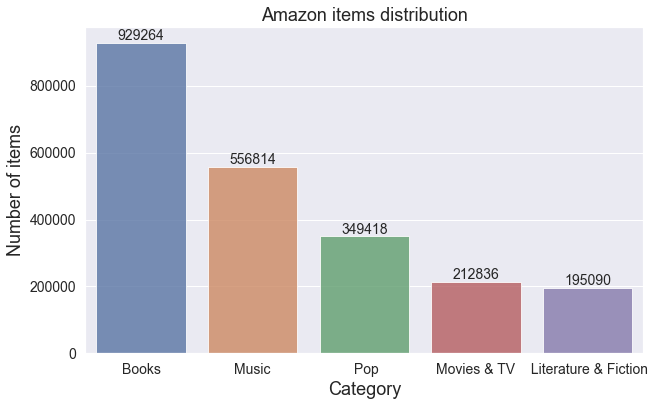

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns

sns.set(font_scale=1.5)

# Get the categories distribution and keep the top 5.
x = df.category.value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:5]

# Create the plot.
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title('Amazon items distribution')
plt.xlabel('Category')
plt.ylabel('Number of items')

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# Add the text labels.
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height+10, label, 
            ha='center', va='bottom', fontsize=14)

The bar plot suggests that the most popular category in the dataset is **Books**, followed by **Music**.

The _parseKeysValues_ method, sequentially reads the keys and stores their value.

In [94]:
# Method for reading the keys/values in the file.
def parseKeysValues(filename):
  entry = {}
  f = gzip.open(filename, 'rb')
  
  # Iterate over all lines in the file.
  for l in f:
    l = l.strip()
    # The key/value pairs are separated by a colon.
    colonPos = l.find(b':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    key = l[:colonPos].decode("latin-1")
    value = l[colonPos+2:].decode("latin-1")
    entry[key] = value
  yield entry

We can create a method to read the review data.

In [95]:
# Method for reading the reviews file.
def readReviews(path, num=-1):
  i = 0
  df = {}
  for d in parseKeysValues(path):
    df[i] = d
    i += 1
    if i == num:
      break
  return pd.DataFrame.from_dict(df, orient='index')

We can now call the _readReviews_ method.

In [96]:
df_reviews = readReviews('./data/Software.txt.gz')

# Make the scores as float values.
df_reviews['review/score'] = df_reviews['review/score'].astype(float)

df_reviews[['product/productId', 'review/score', 'review/text']].tail()

,product/productId,review/score,review/text
95079,B000068VAN,3.0,I purchased this game for my 5 year old twin b...
95080,B000068VAN,3.0,"my four year old likes this game, but sometime..."
95081,B000068VAX,1.0,Got this for my daughter and she can't even pl...
95082,B000068VAX,5.0,Clifford Musical Memory GamesI bought this for...
95083,B000063W5A,5.0,STATVIEW is one of the more popular statistica...


We also need to include the product category in the data.

In [97]:
df_reviews = pd.merge(df_reviews, df_merged, on='product/productId', how='left')

df_reviews[['product/productId', 'review/score', 'review/text', 'category']].tail()

,product/productId,review/score,review/text,category
95079,B000068VAN,3.0,I purchased this game for my 5 year old twin b...,Software Children's Games
95080,B000068VAN,3.0,"my four year old likes this game, but sometime...",Software Children's Games
95081,B000068VAX,1.0,Got this for my daughter and she can't even pl...,Software Children's Art & Creativity Early ...
95082,B000068VAX,5.0,Clifford Musical Memory GamesI bought this for...,Software Children's Art & Creativity Early ...
95083,B000063W5A,5.0,STATVIEW is one of the more popular statistica...,Software Education & Reference Test Preparation


Let’s get the total number of samples.

In [98]:
df_reviews.shape

(95084, 11)

We know that the dataset in the online repository contains duplicates, which we remove with the code snippet that follows.

In [99]:
# The dataset is known to contain duplicates.
df_reviews = df_reviews.drop_duplicates(subset=['review/userId','product/productId'], keep='first', inplace=False)

df_reviews.shape

(84991, 11)

We can reduce its size by filtering the set with a specific sub-category.

In [100]:
# Keep only the reviews for the Software category (in practice all).
df_software = df_reviews.loc[[i for i in df_reviews['category'].index if re.search('Software', df_reviews['category'][i])]]

df_reviews.shape

(84991, 11)

Next, we explore the scores and calculate their frequency.

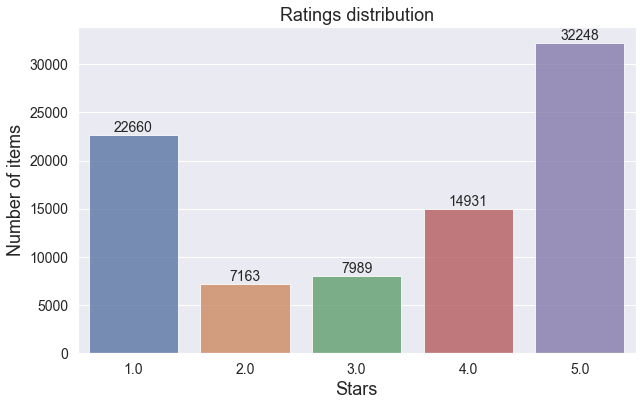

In [101]:
# Get the rating distribution.
x = df_software['review/score'].value_counts()
x = x.sort_index()

# Create the plot.
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title('Ratings distribution')
plt.xlabel('Stars')
plt.ylabel('Number of items')

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# Add the text labels.
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height+10, label, 
            ha='center', va='bottom', fontsize=14)

According to the plot, there are more ratings in the two extremes (**1.0** and **5.0**).

More information about the distribution of the software items is shown in the following bar chart.

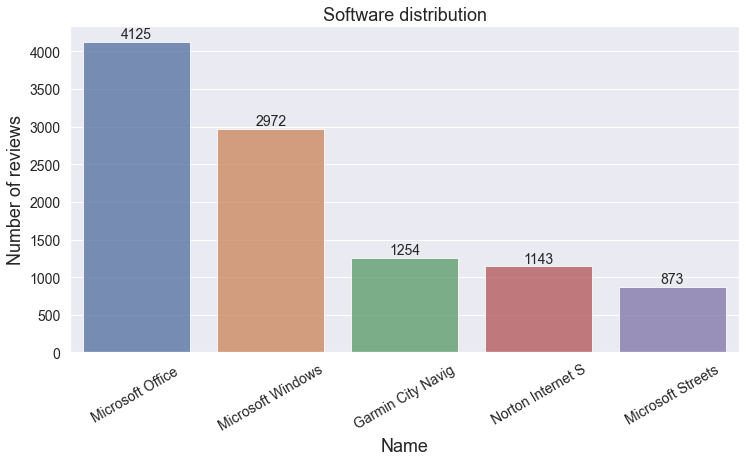

In [102]:
# Get the software distribution and keep the top 5.
x = df_software['product/title'].str[0:17].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:5]

# Create the plot.
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title('Software distribution')
plt.xlabel('Name')
plt.ylabel('Number of reviews')
plt.xticks(rotation=30)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# Add the text labels.
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height+10, label,
            ha='center', va='bottom', fontsize=14)


The box plot below summarizes the ratings for various software items.

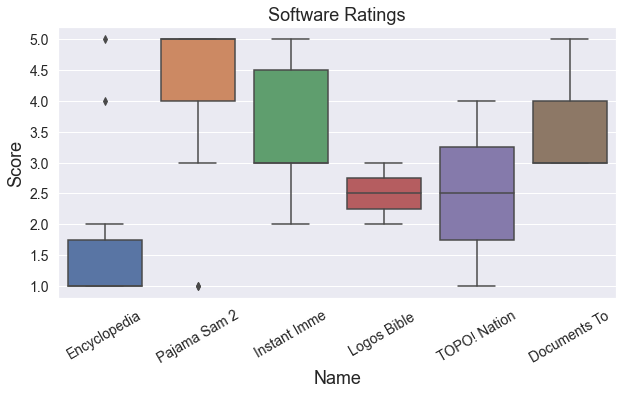

In [103]:
# Get the data for specific software.
df_software_sub = df_software.loc[
    (df_software['product/title'].str.match(r'Documents To Go Premium Edition')) |
    (df_software['product/title'].str.match(r'TOPO! National Geographic.* York')) |
    (df_software['product/title'].str.match(r'Pajama Sam 2 Thunder and Lightning')) |
    (df_software['product/title'].str.match(r'Instant Immersion French: "New')) |
    (df_software['product/title'].str.match(r'Encyclopedia Britannica 2000 Deluxe')) |
    (df_software['product/title'].str.match(r'Logos Bible Atlas')) |
    (df_software['product/title'].str.match(r'Instant Immersion German Platinum')) ] 

# Reduce the name of the title.
df_software_sub['product/shorttitle'] = df_software_sub['product/title'].str[0:12]

# Create the plot.
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='product/shorttitle', y='review/score', data=df_software_sub)
plt.title('Software Ratings')
plt.xlabel('Name')
plt.ylabel('Score')
plt.xticks(rotation=30)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

Based on the figure, only the **Logos Bible** and **TOPO! Nation** products have symmetric scores. Additionally, there are outliers for the **Encyclopedia** and **Pajama Sam 2** cases.

Then, we can calculate the distribution of the reviews based on their word count.

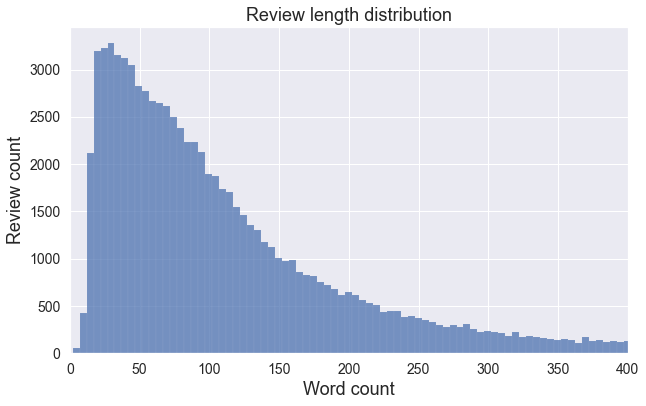

In [104]:
review_length = df_reviews['review/text'].apply(lambda col: len(col.split(' ')))
df_reviews['review_length'] = review_length

# Create the plot.
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=review_length)
plt.xlim(0, 400)
plt.title('Review length distribution')
plt.xlabel('Word count')
plt.ylabel('Review count')

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

As we can observe from the plot, most reviews have fewer than 100 words.

We define the most active (top) reviewers in terms of their review count (more than 50 items). Now, let's extract the IDs of the specific users.

In [105]:
# Get the number of reviews per user.
reviewers = df_reviews.groupby(by=['review/userId'], as_index=False).count().sort_values(by=['product/productId'], ascending=False)
reviewers = reviewers[['review/userId', 'product/productId']]
reviewers.columns = ['review/userId', 'review/count']

# Store the top reviewers.
top_reviewers = reviewers[reviewers['review/count'] >= 50]
top_reviewers = top_reviewers[['review/userId']]

print(top_reviewers)

        review/userId
68463         unknown
2896   A15S4XW3CRISZ5
53129   A5JLAU2ARJ0BO


Only three users adhere to the count criterion.

Next, we apply a second restriction and keep reviews with fewer than 400 words.

In [106]:
# Extract the data for top reviewers.
top_rev_help = pd.merge(top_reviewers, df_reviews, on='review/userId', how='left')
top_rev_help = top_rev_help[top_rev_help['review/userId'] != 'unknown']
top_rev_help = top_rev_help[top_rev_help['review_length'] < 400]
top_rev_help = top_rev_help.sort_values(by=['review/score'], ascending=False)

# Calculate helpfulness score.
top_rev_help['review/helpscore'] = top_rev_help['review/helpfulness'].str.replace('/0', '/1')
top_rev_help['review/helpscore'] = top_rev_help['review/helpscore'].fillna(1000).apply(pd.eval)

# Format the data.
top_rev_help['reviewers'] = 'top'
top_rev_help = top_rev_help.sort_values(by=['review/score'], ascending=False)
top_rev_help = top_rev_help.reset_index(drop=True)

We generate a relational plot that shows the helpfulness score for each product for the top reviewers.

Text(53.79848046875, 0.5, 'Helpfulness')

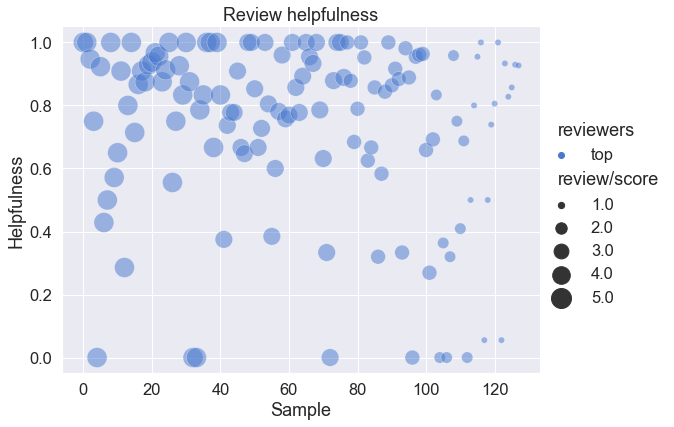

In [107]:
# Create the plot.
ax = sns.relplot(x=top_rev_help.index, y="review/helpscore", hue="reviewers", size="review/score",
            sizes=(40, 400), alpha=.5, palette="muted", 
            height=6, aspect=8/6, data=top_rev_help)

plt.title('Review helpfulness')
plt.xlabel('Sample')
plt.ylabel('Helpfulness')

A general remark from the plot is that the top reviewers’ feedback seems, in the end, helpful to other customers. Most bubbles lie on the upper part of the plot, where helpfulness has high values. Moreover, there are more positive review scores than negative ones, as fewer bubbles have a size equal to **1.0** or **2.0**. 

We repeat a similar procedure for users that have only one review.

In [108]:
# Store the bottom reviewers.
bottom_reviewers = reviewers[reviewers['review/count'] == 1]
bottom_reviewers = bottom_reviewers[['review/userId']]

# Keep 1000 random bottom reviewers.
bottom_reviewers = bottom_reviewers.sample(130, random_state=123)

# Extract the data for bottom reviewers.
bottom_rev_help = pd.merge(bottom_reviewers, df_reviews, on='review/userId', how='left')
bottom_rev_help = bottom_rev_help[bottom_rev_help['review_length'] < 400]
bottom_rev_help = bottom_rev_help.sort_values(by=['review/score'], ascending=False)

# Calculate helpfulness score.
bottom_rev_help['review/helpscore'] = bottom_rev_help['review/helpfulness'].str.replace('/0', '/1')
bottom_rev_help['review/helpscore'] = bottom_rev_help['review/helpscore'].fillna(1000).apply(pd.eval)

# Format the data.
bottom_rev_help['reviewers'] = 'bottom'
bottom_rev_help = bottom_rev_help.sort_values(by=['review/score'], ascending=False)
bottom_rev_help = bottom_rev_help.reset_index(drop=True)

Next, we create a similar bubble plot.

Text(53.79848046875, 0.5, 'Helpfulness')

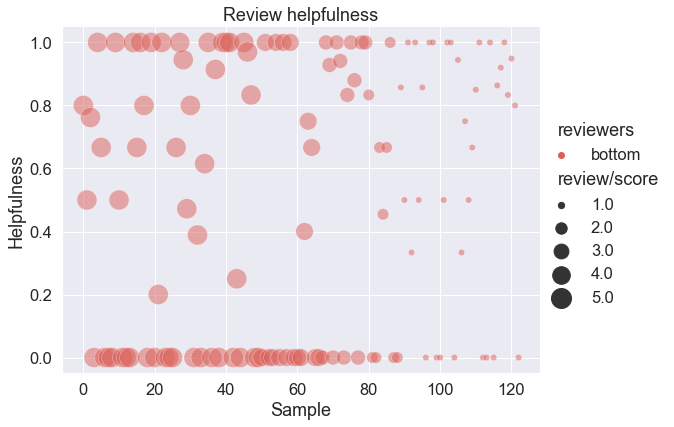

In [109]:
# Create the plot.
ax = sns.relplot(x=bottom_rev_help.index, y="review/helpscore", hue="reviewers", size="review/score",
            sizes=(40, 400), alpha=.5, palette="hls", 
            height=6, aspect=8/6, data=bottom_rev_help)

plt.title('Review helpfulness')
plt.xlabel('Sample')
plt.ylabel('Helpfulness')

Contrasting the two bubble plots, we observe more reviews with low helpfulness in the second one. A large proportion exhibits a score equal to **0.0**. Additionally, there are more negative reviews (bubbles with a size of either **1.0** or **2.0**). Both results suggest that evaluations from top reviewers with positive scores increase the review helpfulness for a given product.

Next, we create elaborate graphs and examine the two top reviewers individually based on their helpfulness scores. But first, we need to restructure the data in a suitable format.

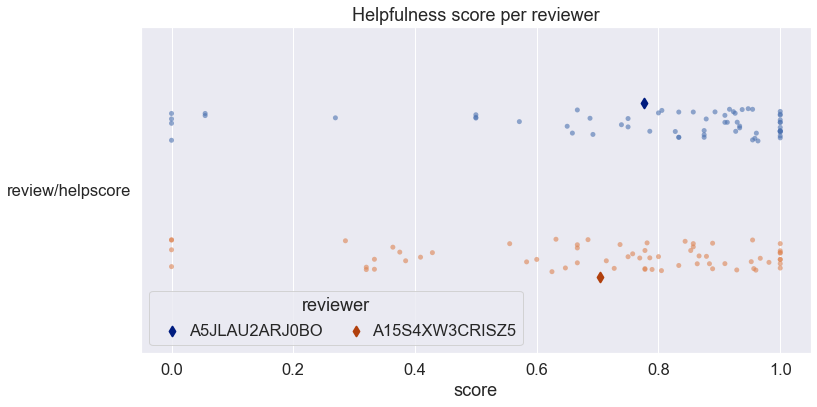

In [110]:
# Unpivot the dataframe from wide to long format. 
stripplot_df = pd.melt(top_rev_help[['review/userId', 'review/helpscore']], "review/userId", var_name="m")

# Create the plots.
f, ax = plt.subplots()
f.set_figheight(6)
f.set_figwidth(12)

# Create a plot to show the helpfulness score per reviewer.
sns.stripplot(x="value", y="m", hue="review/userId",
              data=stripplot_df, dodge=True, 
              alpha=.6, zorder=1)

# Show the conditional means of the scores.
sns.pointplot(x="value", y="m", hue="review/userId",
              data=stripplot_df, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=1, ci=None)

plt.title('Helpfulness score per reviewer')
plt.xlabel('score')
plt.ylabel('')

# Configure the legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="reviewer",
          handletextpad=0, columnspacing=1,
          loc="lower left", ncol=3, frameon=True)

Both reviewers receive high scores for their product evaluations.

## Linear Regression

`Linear regression` aims to find the best relationship between x (independent variable) and y (dependent variable) and is perhaps one of the most well-known algorithms in statistics and machine learning.

We provide an example using data coming from a survey that reports the state of global happiness for 155 countries, named the [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness). The following code loads and formats the samples.

Text(0, 0.5, 'Happiness score')

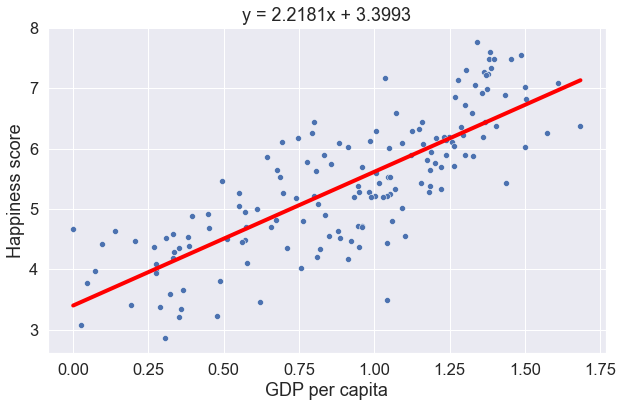

In [111]:
from sklearn.linear_model import LinearRegression

# Read the data from the csv file.
data = pd.read_csv('./data/2019.csv')

# Keep these two categories.
x = data['GDP per capita']
y = data['Score']

# Reshape the data.
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

# Create and fit the linear regression model.
lmodel = LinearRegression()
lmodel.fit(x, y)

# Get the predictions.
predictions = lmodel.predict(x)

# Create a dataframe with the data.
linear_df = pd.DataFrame(data, columns=['GDP per capita', 'Score'])
linear_df['Predictions'] = predictions

# Create the plot.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=linear_df, x='GDP per capita', y='Score')
sns.lineplot(data=linear_df, x="GDP per capita", y="Predictions", color='red', linewidth=4)
plt.title("y = {:.5}x + {:.5}".format(lmodel.coef_[0][0], lmodel.intercept_[0]))
plt.xlabel('GDP per capita')
plt.ylabel('Happiness score')

#plt.show()

The regression line with a slope of **2.2181** and point of intercept with the y axis equal to **3.3993** can help us predict the future.

## Logistic Regression

`Logistic regression` is one of the most popular supervised machine learning algorithms, and it's used mainly for classification problems. The output of a logistic regression problem is between 0 and 1.

We can proceed with creating the training and test sets and perform sentiment analysis. Extracting a binary sentiment label for each sample in the dataset is based on the score assigned by the reviewer. Thus, in the following code snippet, we set all ratings with a score equal to or less than 3 to signify a negative review. A value above 3 denotes the opposite.

In [112]:
# Keep only the review text and score.
df = df_software[['review/text', 'review/score']]

# Every rating below or equal to 3 is considered negative (0) and above 3 positive (1).
df['label'] = df['review/score'].apply(lambda x: 0 if x <= 3  else 1)

df.head()

,review/text,review/score,label
0,I bought this software for my 5 year old. He h...,2.0,0
2,It clearly says on line this will work on a Ma...,1.0,0
5,I gave this game to my son as an early birthda...,5.0,1
7,I think this one is our favourite game for my ...,4.0,1
8,"It is great, my girl is just 5 and speak no en...",5.0,1


We also check the number of positive and negative samples.

In [113]:
# Count the number of samples for each label.
df.label.value_counts()

1    47179
0    37812
Name: label, dtype: int64

The output suggests that the chosen threshold provides a relatively balanced dataset. We can now proceed and vectorize the text of the reviews.

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Get the training and test sets.
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=123)
	
# Create the count vectorizer.
vectorizer = CountVectorizer(binary=True)

# Fit on the training data and get the count vectors. 
vectorizer.fit_transform(df_train['review/text'].values)
countvect_train = vectorizer.transform(df_train['review/text'].values)
countvect_test = vectorizer.transform(df_test['review/text'].values)

# Get the class arrays.
train_class = df_train['label'].values
test_class = df_test['label'].values

As all datasets are now in place, we can proceed to the classification step.

The baseline performance allows us to benchmark the logistic regression model.

In [115]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

print("The baseline accuracy is: " + str(df[df.label == 1].shape[0]/df.shape[0]))

The baseline accuracy is: 0.5551058347354426


Next, we create, train, and evaluate the classifier.



In [116]:
# Create the classifier.
classifier = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, random_state=123)

# Fit the classifier with the train data.
classifier.fit(countvect_train, train_class)

# Get the predicted classes.
test_class_pred = classifier.predict(countvect_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.7882971213428505

The obtained accuracy is around 79%, better than the baseline but still mediocre.

Let’s check the performance on the training set.

In [117]:
# Get the predicted classes.
test_class_pred = classifier.predict(countvect_train)

# Calculate the accuracy on the test set.
metrics.accuracy_score(train_class, test_class_pred)

0.9999663825996336

We apply `regularization` to the problem under study. Regularization discourages learning a more complex or flexible model to prevent overfitting.

In [118]:
# Create the classifier.
classifier = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000, random_state=123)

# Fit the classifier with the train data.
classifier.fit(countvect_train, train_class)

# Get the predicted classes.
test_class_pred = classifier.predict(countvect_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.8524197976311868

Regularization worked favorably for the classification task, and the performance improved significantly.

## Deep Neural Networks

An `artificial neural network` (ANN) is a collection of connected nodes (artificial neurons) stacked in layers. The network includes a series of hidden layers, where the true values of their nodes are unknown and consequently hidden from the input data. They are the secret sauce of an ANN and provide their special power. Networks with many hidden layers are called `deep neural networks`.

Let's create our own for the problem under study.

In [119]:
import tensorflow
tensorflow.random.set_seed(2)
from numpy.random import seed
seed(1)
from keras.layers import Dropout, Dense
from keras.models import Sequential

node_num = 256
layers_num = 4
dropout = 0.5

# Create the linear stack of layers model.
model = Sequential()

# Create the input layer.
model.add(Dense(node_num, input_dim=countvect_train.shape[1], activation='relu'))
model.add(Dropout(dropout))

# Create the hidden layers.
for i in range(0, layers_num):
    model.add(Dense(node_num, input_dim=node_num, activation='relu'))
    model.add(Dropout(dropout))

# Create the output layer.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer='adam', metrics=['accuracy'])
			  
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               19297024  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 256)              

The parameters that need to be estimated, are around 20 million.

We can also visualize the model as a graph using the following code.

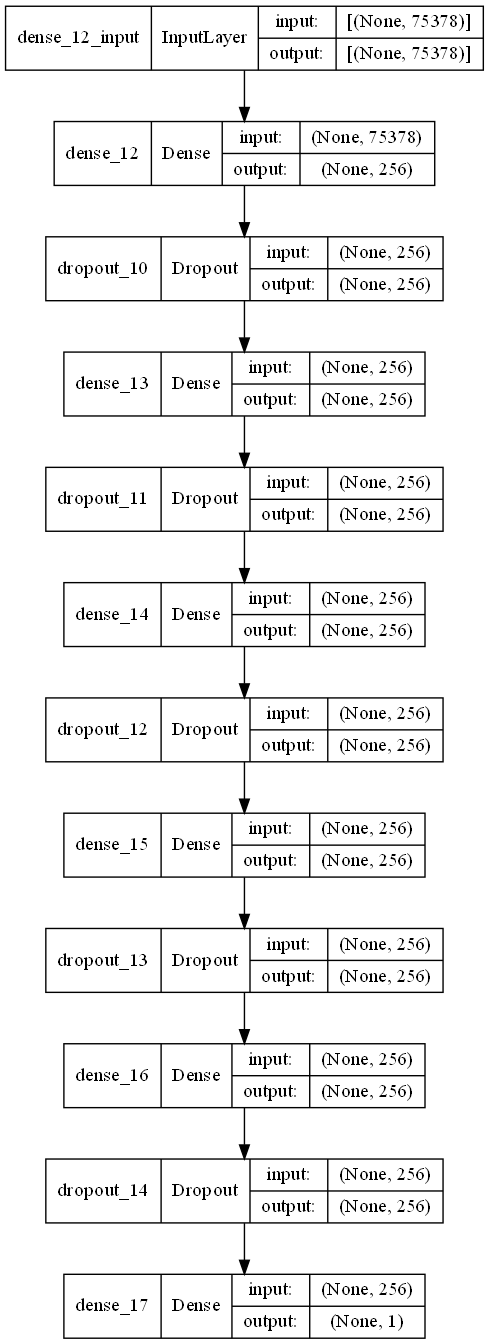

In [120]:
from tensorflow.keras.utils import plot_model

# Plot the model.
plot_model(model, to_file='./images/model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

Last, we can train the model for 10 epochs and use a _batch_size_ value of _128_ samples.



In [121]:
# Fit the classifier with the train data.
model.fit(countvect_train, train_class,
          validation_data=(countvect_train, train_class),
          epochs=10, batch_size=128, verbose=2)

Epoch 1/10


c:\Users\tsouraki\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


465/465 - 38s - loss: 0.4076 - accuracy: 0.8151 - val_loss: 0.2472 - val_accuracy: 0.9113 - 38s/epoch - 83ms/step
Epoch 2/10
465/465 - 36s - loss: 0.2704 - accuracy: 0.8917 - val_loss: 0.1748 - val_accuracy: 0.9429 - 36s/epoch - 78ms/step
Epoch 3/10
465/465 - 36s - loss: 0.1987 - accuracy: 0.9257 - val_loss: 0.1017 - val_accuracy: 0.9720 - 36s/epoch - 77ms/step
Epoch 4/10
465/465 - 36s - loss: 0.1462 - accuracy: 0.9471 - val_loss: 0.0616 - val_accuracy: 0.9864 - 36s/epoch - 78ms/step
Epoch 5/10
465/465 - 36s - loss: 0.1103 - accuracy: 0.9618 - val_loss: 0.0502 - val_accuracy: 0.9895 - 36s/epoch - 77ms/step
Epoch 6/10
465/465 - 36s - loss: 0.0865 - accuracy: 0.9703 - val_loss: 0.0266 - val_accuracy: 0.9950 - 36s/epoch - 76ms/step
Epoch 7/10
465/465 - 36s - loss: 0.0724 - accuracy: 0.9750 - val_loss: 0.0162 - val_accuracy: 0.9968 - 36s/epoch - 78ms/step
Epoch 8/10
465/465 - 35s - loss: 0.0610 - accuracy: 0.9793 - val_loss: 0.0117 - val_accuracy: 0.9979 - 35s/epoch - 76ms/step
Epoch 9/10


The accuracy quickly reaches 98%, and we can now perform the real benchmark using the test data. As the predictions stem from a sigmoid function, we normalize them into two distinctive levels using the value _0.5_ as a threshold.

In [122]:
# Get the predicted classes.
test_class_pred = model.predict(countvect_test)

# Normalize the predicted values to either 0 or 1.
test_class_pred = [(1 if i>0.5 else 0) for i in test_class_pred]

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.8555180798494

The model off ers an accuracy of around 86%, close to the result obtained for the logistic regression case with regularization.

## What we have learned …

| | | |
| --- | --- | --- |
| **Visualizations**<ul><li>Bar charts</li><li>Box plots</li><li>Histograms</li><li>Bubble plots</li><li>Scatter plots</li></ul> | **ML concepts**<ul><li>Regression</li><li>Optimization</li><li>Regularization</li><li>Gradient descent</li></ul> | **ML algorithms & models**<ul><li>Linear Regression</li><li>Logistic Regression</li><li>Deep Neural Networks</li></ul> |
| **Performance metrics**<ul><li>Loss fucntions</li><li>Principle of least squares</li></ul> | | |
| | | |

## Author Information

- **Author:** Nikos Tsourakis
- **Email:** nikos@tsourakis.net
- **Website:** [tsourakis.net](https://tsourakis.net)
- **Date:** November 20, 2023